# <center>Final Project; Algorithms in Modern Statistics </center>
**Submitted by**: 
**<center>Full Names: Matan Mizrachi, Eyal Stolov</center>**

The following project is fully based on the data, that could be found and explained [here](https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students).

You might also need to run the next block.

In [1]:
#!pip install plotly-express
#!pip install tqdm

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
from tqdm.notebook import tqdm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from scipy.stats import ttest_ind, ttest_rel, mannwhitneyu, f_oneway

from itertools import combinations, permutations, product
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
tqdm.pandas()

## Useful Functions

### Plottings

In [3]:
def plot_decomposition(est, data: pd.DataFrame, color, dim=2, method='px', hover_data=None, marker=None,
                       exclude_dtypes=None, drop_color=False,
                       drop_columns=None, title='', return_estimator=False):
    _df = data.copy()
    if drop_columns:
        _df = _df.drop(columns=drop_columns)
    if exclude_dtypes:
        _df = _df.select_dtypes(exclude=exclude_dtypes)
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].progress_apply(lambda _z: _z.astype('category').cat.codes)
    color = _df[color].copy() if method == 'plt' else data[color].copy()
    _df = _df.drop(columns = [color.name]) if color.name in _df.columns and drop_color else _df

    est = est.fit(StandardScaler().fit_transform(_df))
    _x = est.transform(StandardScaler().fit_transform(_df))
    
    dim_cols = [f'PC{i} : Most Important - {_df.columns[np.abs(est.components_[i-1]).argmax()]}' for i in range(1, dim+1)]
    _x = pd.DataFrame(_x[:, :dim], columns=dim_cols)
    
    if hover_data:
        if type(hover_data) == str:
            hover_data = [hover_data]
        _x[hover_data] = data[hover_data]
    else:
        hover_data = _df.columns
        _x[hover_data] = data[hover_data]

    _x[color.name] = color
    
    if dim == 2:      
        if method == 'px':
            fig = px.scatter(_x, x=dim_cols[0], y=dim_cols[1], color=color.name, hover_data=hover_data, symbol=marker)
        elif method == 'plt':
            cax = plt.scatter(_x[dim_cols[0]], _x[dim_cols[1]], c=color)
            plt.xlabel(dim_cols[0])
            plt.ylabel(dim_cols[1])

    elif dim == 3:
        if method == 'px':
            fig = px.scatter_3d(_x, x=dim_cols[0], y=dim_cols[1], z=dim_cols[2], color=color.name, 
                                hover_data=hover_data, symbol=marker)
        elif method == 'plt':
            ax = plt.axes(projection='3d')
            cax = ax.scatter(_x[dim_cols[0]], _x[dim_cols[1]], _x[dim_cols[2]], c=color, marker='o')
            plt.xlabel(dim_cols[0])
            plt.ylabel(dim_cols[1])
            ax.set_zlabel(dim_cols[2])
    if method == 'px':
        fig.update_layout(
            title={
                'text': title,
                'x': 0.5,
                'y': 0.95,
                'xanchor': 'center',
                'yanchor': 'top'}, coloraxis_colorbar=dict(yanchor="top", x=-0.25,y=1))
        
        fig.show()
    else:
        plt.title(title)
        plt.colorbar(cax, ticks=np.unique(color))
        plt.show()
    if return_estimator:
        return est
    

def biplot(est, data, method='plt'):
    _df = data.copy()
    _df.loc[:, _df.dtypes == object] = _df.loc[:, _df.dtypes == object].progress_apply(lambda _z: _z.astype('category').cat.codes)
    feature_names = _df.columns
    est = est.fit(StandardScaler().fit_transform(_df))
    loadings = est.components_.T * np.sqrt(est.explained_variance_)
    
    for i, (_x, _y) in enumerate(loadings):
        if method == 'plt':
            plt.annotate(feature_names[i], (0, 0), (_x , _y), arrowprops = {'arrowstyle': '<-', 'color': 'black'})
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.show()

### DataFrame Transformations

In [4]:
def split_xy(data: pd.DataFrame, by: str, x: str = None):
    new_df = []
    for _val in data[by].unique():
        if x is not None:
            new_df.append(data.loc[data[by] == _val, x].copy().reset_index(drop=True))
        else:
            new_df.append(data.loc[data[by] == _val].copy().reset_index(drop=True))
    return new_df

def corr_categorical(data, features):
    _df = data.copy()
    _df[features] = _df[features].progress_apply(lambda _z: _z.astype('category').cat.codes)
    
    return _df[features].corr()

In [3]:
df = pd.read_csv('archive/test_scores.csv')
df['lunch'] = df['lunch'].apply(lambda _z: _z if _z == 'Does not qualify' else 'Qualifies')
df.head()

school school_setting school_type classroom teaching_method  n_student  \
0  ANKYI          Urban  Non-public       6OL        Standard       20.0   
1  ANKYI          Urban  Non-public       6OL        Standard       20.0   
2  ANKYI          Urban  Non-public       6OL        Standard       20.0   
3  ANKYI          Urban  Non-public       6OL        Standard       20.0   
4  ANKYI          Urban  Non-public       6OL        Standard       20.0   

  student_id  gender             lunch  pretest  posttest  
0      2FHT3  Female  Does not qualify     62.0      72.0  
1      3JIVH  Female  Does not qualify     66.0      79.0  
2      3XOWE    Male  Does not qualify     64.0      76.0  
3      556O0  Female  Does not qualify     61.0      77.0  
4      74LOE    Male  Does not qualify     64.0      76.0

## Part 1: EDA
The following part contains of:
- Data Visualizations
- General Statistics of Each Feature
- Visualizing Relationships Between Features
- Dimensionality Reduction

### Categorical Data

In [4]:
df.describe(include='object')

school school_setting school_type classroom teaching_method student_id  \
count    2133           2133        2133      2133            2133       2133   
unique     23              3           2        97               2       2133   
top     GOOBU          Urban      Public       18K        Standard      LLVCV   
freq      158            906        1582        31            1373          1   

       gender             lunch  
count    2133              2133  
unique      2                 2  
top      Male  Does not qualify  
freq     1077              1215

Based on the tables above, we can basically dismiss the *student_id* feature, as its variety leads to no valuable information to be gained out of it.

In [4]:
df = df.drop(columns=['student_id'])

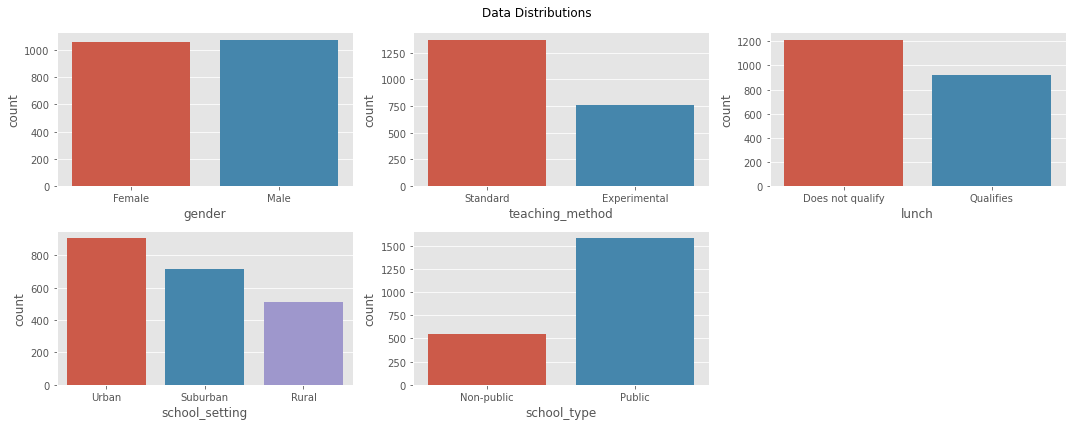

In [5]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    plt.subplot(2, 3, i+1)
    sns.countplot(df[c])
plt.tight_layout()
plt.show()

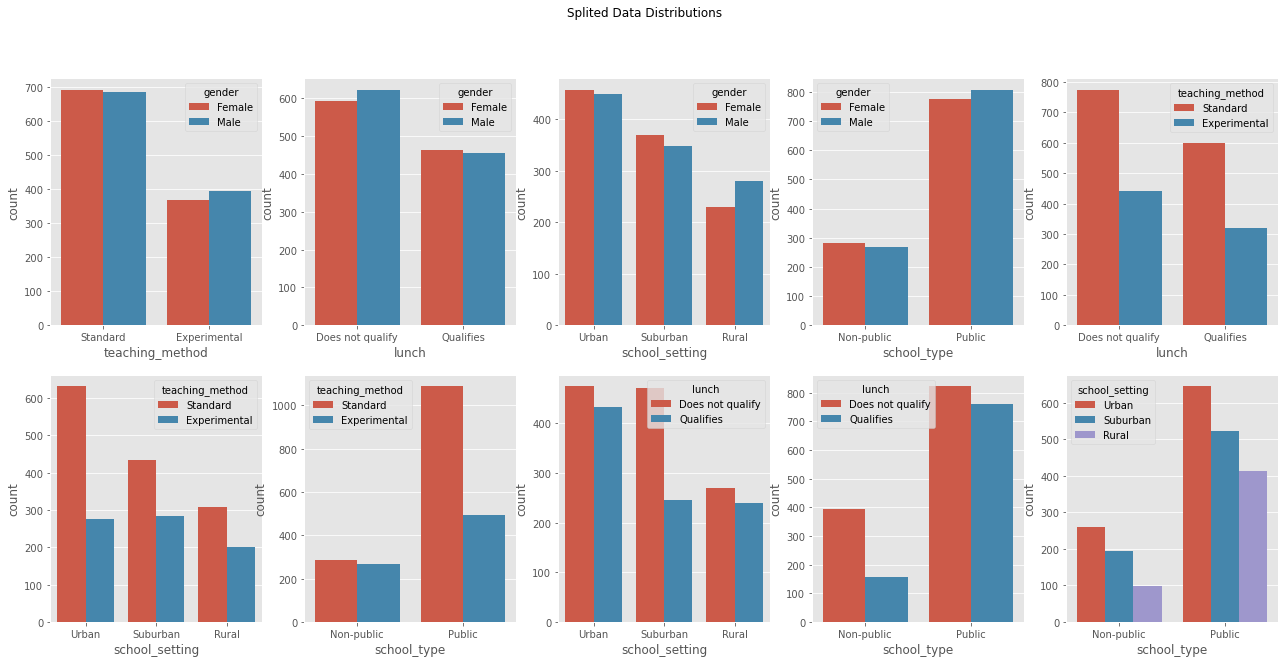

In [6]:
plt.figure(figsize=(22, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
        if j <= i:
            continue
        plt.subplot(2, 5, index)
        index += 1
        sns.countplot(data=df, x=col, hue=hue)
plt.show()

We can already see differences in some of the features distributions when dividing them into separated groups;
- School type, divided by teaching method
- School type, divided by *lunch* feature
- Genders in different school settings

### Numeric Data

In [17]:
df.describe()

n_student      pretest     posttest
count  2133.000000  2133.000000  2133.000000
mean     22.796531    54.955931    67.102203
std       4.228893    13.563101    13.986789
min      14.000000    22.000000    32.000000
25%      20.000000    44.000000    56.000000
50%      22.000000    56.000000    68.000000
75%      27.000000    65.000000    77.000000
max      31.000000    93.000000   100.000000

In [8]:
plt.figure(figsize=(15, 6))
plt.suptitle('Data Distributions')
for i, c in enumerate(['n_student', 'pretest', 'posttest']):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=df, x=c, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

In [11]:
plt.figure(figsize=(20, 10))
plt.suptitle('Splited Data Distributions')
index = 1
for i, hue in enumerate(['gender', 'teaching_method', 'lunch', 'school_setting', 'school_type']):
    for j, col in enumerate(['n_student', 'pretest', 'posttest']):
        plt.subplot(5, 3, index)
        index += 1
        sns.histplot(data=df, x=col, hue=hue, kde=True, stat='density', ax=plt.gca())
plt.tight_layout()
plt.show()

In [12]:
sns.heatmap(df[['n_student', 'pretest', 'posttest']].corr(), annot=True)
plt.title('Pearson Correlation Matrix')
plt.show()

Clearly, the pretest and posttest scores are very highly correlated, almost as if these were the same features to work with.


In [5]:
df = df.drop(columns=['pretest'])

Another interesting thing to investigate is whether the number of students in a class affects, significantly, the class GPA.

In [9]:
plt.subplot(1, 2, 1)
plt.title('posttest scores x n_student aggregated over classes')
t_df = df.groupby('classroom').mean()
t_df['n_student'] = t_df['n_student'].astype(int)
sns.set_theme(rc={'figure.figsize':(15,5)})
sns.barplot(data=t_df,x='n_student',y='posttest',ci=100)

plt.subplot(1, 2, 2)
plt.title('Spearman Correlation Matrix (n_student x posttest)')
sns.heatmap(t_df[['n_student', 'posttest']].corr(method='spearman'), annot=True)

plt.show()

t_df = None
del(t_df)

We can see that the GPA of classes with 23 students or less are above 60 (passing grade). However, the spearman correlation coefficient between the two groups seems to be very low. We can have an hypothesis test on whether the difference of GPA between classes of 23 and less students is significant of class with 24 and more students.

In [19]:
est = plot_decomposition(est=PCA(n_components=2, svd_solver='full'), data=df, color='school_type', marker='lunch',
                         return_estimator=True, title='PCA over Numeric Data', dim=2,
                         drop_columns=['school', 'classroom'], drop_color=False, exclude_dtypes=None)

  0%|          | 0/5 [00:00<?, ?it/s]

In [20]:
biplot(PCA(n_components=2, svd_solver='full'), df.drop(columns=['classroom', 'school']))

  0%|          | 0/5 [00:00<?, ?it/s]

## Part 2: Hypothesis Testing

We will be using a 5% significance value

In [133]:
#Matan this are helping functions, I didnt put them in the 'Useful Functions' so you wont miss them.
def cohens_d(data: pd.DataFrame,a,b,feature='posttest'):
    return (np.absolute(np.mean(a)-np.mean(b))/np.std(data[feature]))

def test_check(result:list,significance_value=0.05):
    if result[1]>significance_value:
        print('Fail! The null hypothesis is true!\n')
    else:
        print('Pass! We reject the null hypothesis!\n')
    
def effect_size_check(result,check_by=[0.2,0.5,0.8]):
        if effect_size>check_by[2]:
            print('Large Effect!\n')
        else:
            if effect_size>check_by[1]:
                print('Medium Effect!\n')
            else:
                print('Small Effect!\n')

### One-way ANOVE test

In [132]:
check=['school_type', 'teaching_method', 'gender', 'lunch']
for feature in check:
    a, b = split_xy(df, feature, 'posttest')
    result=f_oneway(a, b)
    print(feature,'(',df[feature].unique(),') :',result)
    test_check(result)
    
a,b,c=split_xy(df, 'school_setting', 'posttest')
area=df['school_setting'].unique()
for i in combinations([[area[0],a],[area[1],b],[area[2],c]],2):
    result=f_oneway(i[0][1],i[1][1])
    print('school_setting','(',i[0][0],',',i[1][0],')',result)
    test_check(result)

school_type ( ['Non-public' 'Public'] ) : F_onewayResult(statistic=346.36982073181076, pvalue=9.375658077323967e-72)
Pass! We reject the null hypothesis!

teaching_method ( ['Standard' 'Experimental'] ) : F_onewayResult(statistic=231.25681659751112, pvalue=1.1640893397300103e-49)
Pass! We reject the null hypothesis!

gender ( ['Female' 'Male'] ) : F_onewayResult(statistic=0.10151953331754493, pvalue=0.7500449231811932)
Fail! The null hypothesis is true!

lunch ( ['Does not qualify' 'Qualifies'] ) : F_onewayResult(statistic=1188.5615435419354, pvalue=2.2616015547519054e-207)
Pass! We reject the null hypothesis!

school_setting ( Urban , Suburban ) F_onewayResult(statistic=520.1783666609288, pvalue=4.3491372162338055e-100)
Pass! We reject the null hypothesis!

school_setting ( Urban , Rural ) F_onewayResult(statistic=10.119836396166109, pvalue=0.0014986845845742932)
Pass! We reject the null hypothesis!

school_setting ( Suburban , Rural ) F_onewayResult(statistic=324.1528417453372, pvalu

### Mann-Whitney U rank test

In [124]:
check=['school_type', 'teaching_method', 'gender', 'lunch']
for feature in check:
    a, b = split_xy(df, feature, 'posttest')
    result=mannwhitneyu(a, b)
    print(feature,'(',df[feature].unique(),') :',result)
    test_check(result)
    
a,b,c=split_xy(df, 'school_setting', 'posttest')
area=df['school_setting'].unique()
for i in combinations([[area[0],a],[area[1],b],[area[2],c]],2):
    result=mannwhitneyu(i[0][1],i[1][1])
    print('school_setting','(',i[0][0],',',i[1][0],')',result)
    test_check(result)

school_type ( ['Non-public' 'Public'] ) : MannwhitneyuResult(statistic=208085.5, pvalue=4.379396959105047e-75)
Pass! We reject the null hypothesis!

teaching_method ( ['Standard' 'Experimental'] ) : MannwhitneyuResult(statistic=325111.5, pvalue=1.5027272495779604e-47)
Pass! We reject the null hypothesis!

gender ( ['Female' 'Male'] ) : MannwhitneyuResult(statistic=563404.0, pvalue=0.3559352789568585)
Fail! The null hypothesis is true!

lunch ( ['Does not qualify' 'Qualifies'] ) : MannwhitneyuResult(statistic=166515.0, pvalue=3.703987327780685e-170)
Pass! We reject the null hypothesis!

school_setting ( Urban , Suburban ) MannwhitneyuResult(statistic=134683.0, pvalue=9.507035386905277e-92)
Pass! We reject the null hypothesis!

school_setting ( Urban , Rural ) MannwhitneyuResult(statistic=197135.5, pvalue=2.218121937319229e-06)
Pass! We reject the null hypothesis!

school_setting ( Suburban , Rural ) MannwhitneyuResult(statistic=90397.0, pvalue=6.3591875951780025e-52)
Pass! We reject the

## Effect Size

We can see that most tests pass, thus, we can be sure an effect exists between diffrent groups; but how large is the effect?
For that we will use the following method to reveal our Effect Size:

Cohen's d Effect Size can be calculated as followes:
$$\verb|Effect Size| =\frac{M_{0}-M_{1}}{s}$$
Which will then be interrupted by the following table: 

<div>
<img src="cohens_d_table.JPG" width="500"/>
</div>



Between group means, the effect size can also be understood as the average percentile distribution of group 1 vs. that of group 2 or the amount of overlap between the distributions of interventions 1 and 2 for the two groups under comparison. For an effect size of 0, the mean of group 2 is at the 50th percentile of group 1, and the distributions overlap completely (100%)—that is , there is no difference. For an effect size of 0.8, the mean of group 2 is at the 79th percentile of group 1; thus, someone from group 2 with an average score (ie, mean) would have a higher score than 79% of the people from group 1.

In [134]:
check=['school_type', 'teaching_method', 'gender', 'lunch']
for feature in check:
    a, b = split_xy(df, feature, 'posttest')
    effect_size=cohens_d(df,a,b)
    print(feature,'(',df[feature].unique(),') :',effect_size)
    effect_size_check(effect_size)
        
a,b,c=split_xy(df, 'school_setting', 'posttest')
area=df['school_setting'].unique()
for i in combinations([[area[0],a],[area[1],b],[area[2],c]],2):
    effect_size=cohens_d(df,i[0][1],i[1][1])
    print('school_setting','(',i[0][0],',',i[1][0],')',effect_size)
    effect_size_check(effect_size)

school_type ( ['Non-public' 'Public'] ) : 0.8542528128427141
Large Effect!

teaching_method ( ['Standard' 'Experimental'] ) : 0.6533298584540091
Medium Effect!

gender ( ['Female' 'Male'] ) : 0.013804598555277287
Small Effect!

lunch ( ['Does not qualify' 'Qualifies'] ) : 1.2085144587180352
Large Effect!

school_setting ( Urban , Suburban ) 1.0218688105951423
Large Effect!

school_setting ( Urban , Rural ) 0.16466795914057053
Small Effect!

school_setting ( Suburban , Rural ) 0.8572008514545717
Large Effect!



# Part 3: Regression

In [73]:
def encode_labels(data: pd.DataFrame,features):
    new_df=data.copy()
    for i in features:
        new_df[i]=new_df[i].astype('category')
        new_df[i]=new_df[i].cat.codes
    
    return new_df

def weights_by_feature(data: pd.DataFrame,feature, unique, multiply=0):
    weights=pd.Series(np.ones(data.shape[0]),data.index)
    for i in data.index:
        if data[feature].loc[i]!=unique:
            weights[i]=weights[i]*multiply
    return weights

def split_and_stratify_by_feature(data: pd.DataFrame ,feature):
    train,test=train_test_split(data,test_size=0.25, stratify=data[feature])
    test.sort_values(by=feature,inplace=True)
    test.reset_index(drop=True)
    
    target=train['posttest']
    train.drop(['posttest'],axis=1,inplace=True)
    answers=test['posttest']
    test.drop('posttest',axis=1,inplace=True)
    
    return train,test,target,answers

def local_regression_by_feature(train,test,target,feature,multiplay=0):
    lin_reg=LinearRegression()
    sum=0
    predicted=pd.Series(np.zeros(test.shape[0]))
    test.sort_values(by=feature,inplace=True)
    
    for i in test[feature].unique():

        weights=weights_by_feature(train,feature,i,multiplay)
        indexs=test.groupby(feature).count()[test.columns[5]][i]
        lin_reg.fit(train,target,sample_weight=weights)
        temp_predicted=lin_reg.predict(test)

        for j in range(indexs):
            predicted[sum+j]=temp_predicted[sum+j]
        
        sum+=indexs
    
    return predicted

### Linear Regression:

In [8]:
df_reg=encode_labels(df,df.columns.drop(['n_student','posttest']))
lin_reg=LinearRegression()
for feature in df.columns.drop(['n_student','posttest']):
    train,test,target,answers=split_and_stratify_by_feature(df_reg,feature)
    lin_reg.fit(train,target)
    predicted=lin_reg.predict(test)
    print('For feature:',feature,',our calculated MSE is:',mean_squared_error(answers,predicted))

For feature: school ,our calculated MSE is: 87.76437063089152
For feature: school_setting ,our calculated MSE is: 85.48439117741272
For feature: school_type ,our calculated MSE is: 91.51354932633969
For feature: classroom ,our calculated MSE is: 90.66033196332967
For feature: teaching_method ,our calculated MSE is: 90.83780267601949
For feature: gender ,our calculated MSE is: 102.62326277068017
For feature: lunch ,our calculated MSE is: 97.40882051797234


### Local Linear Regression:

In [54]:
feature='school'
multiplay=0
df_reg=encode_labels(df,df.columns.drop(['n_student','posttest']))
for feature in df.columns.drop(['n_student','posttest']):
    train,test,target,answers=split_and_stratify_by_feature(df_reg,feature)
    answers.sort_index().reset_index().drop('index',axis=1)
    for multiplay in np.linspace(0,0.5,3):
        predicted=local_regression_by_feature(train,test,target,feature,multiplay)
        print('For feature:',feature,',and multiplay =',multiplay,',our calculated MSE is:',mean_squared_error(answers,predicted))

For feature: school ,and multiplay = 0.0 ,our calculated MSE is: 20.51345413102618
For feature: school ,and multiplay = 0.25 ,our calculated MSE is: 57.941870268185134
For feature: school ,and multiplay = 0.5 ,our calculated MSE is: 73.03677318259882
For feature: school_setting ,and multiplay = 0.0 ,our calculated MSE is: 51.770371687908586
For feature: school_setting ,and multiplay = 0.25 ,our calculated MSE is: 57.242890699613966
For feature: school_setting ,and multiplay = 0.5 ,our calculated MSE is: 65.4410788266745
For feature: school_type ,and multiplay = 0.0 ,our calculated MSE is: 85.14275930404835
For feature: school_type ,and multiplay = 0.25 ,our calculated MSE is: 84.65741007512796
For feature: school_type ,and multiplay = 0.5 ,our calculated MSE is: 84.63821830030996
For feature: classroom ,and multiplay = 0.0 ,our calculated MSE is: 10.88318726117334
For feature: classroom ,and multiplay = 0.25 ,our calculated MSE is: 65.95764634313744
For feature: classroom ,and multipla

Wow! We can see that when we localize the 'school' feature with a 0 multiplayer, we get a 20.51345 MSE! 
A great improvement compared to normal Linear Regression! 

NOTE: We wont use the 'classroom' feature with 0 multiplayer, even though it got a better MSE, because it will cause an overfit. Further more, its not practical to get a partial classroom data and be asked to predict the missing data.